# 染色体图像自动分割算法

本文探索染色体图像的自动分割算法，排除分割算法中人工干预的过程和超参。允许人工给出部分超参，算法自动调整部分超参。  
算法的基本思路为：
1. 图片二值化处理
2. 二值化图片去噪
3. 去除血细胞
4. 去除离群点


In [1]:
# dependencies

import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import os

In [101]:
# human specified consts

BINARY_THRESHOLD = 225

NOISE_THRESHOLD = 200
OPENING_KERNEL_SIZE = 5

CIRCULARITY_THRESHOLD = 0.7
CELL_THRESHOLD = 7500

DBSCAN_EPS = 200
DBSCAN_SAMPLES = 3

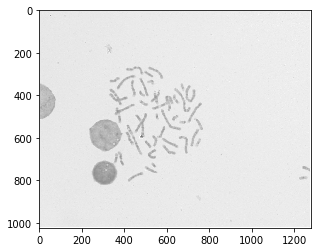

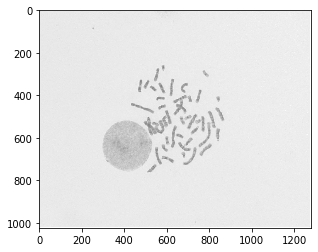

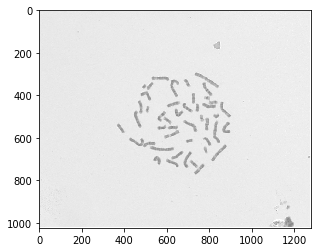

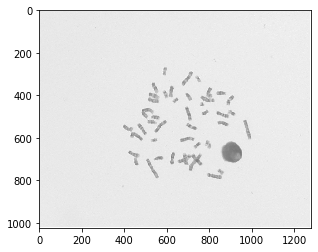

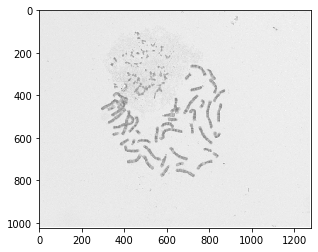

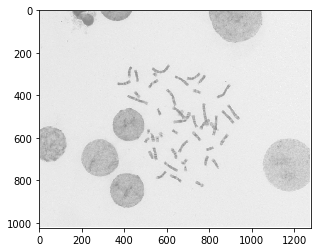

In [102]:
# image list

image_root = './input'

image_list = os.listdir(image_root)
images = [cv2.imread(os.path.join(image_root, image_file)) for image_file in image_list]

for image in images:
    plt.imshow(image)
    plt.show()

## 1. 图片二值化

In [103]:
def binaryzation(img, binary_threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, b_img = cv2.threshold(gray, binary_threshold, 255, cv2.THRESH_BINARY_INV)
    
    return b_img


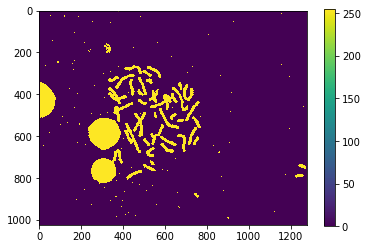

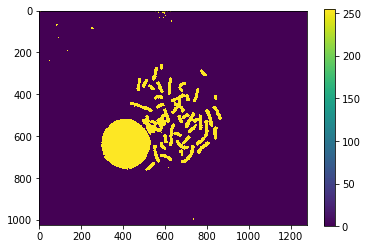

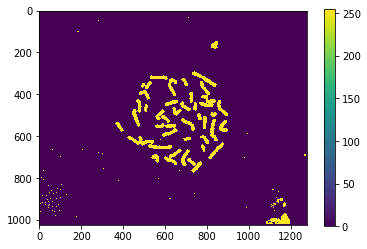

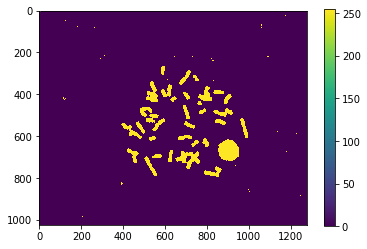

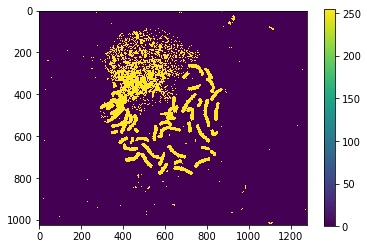

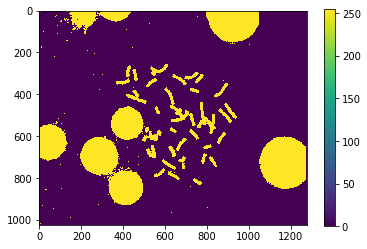

In [104]:
b_imgs = [binaryzation(img, BINARY_THRESHOLD) for img in images]

for b_img in b_imgs:
    plt.imshow(b_img)
    plt.colorbar()
    plt.show()

## 2. 二值化图片去噪

滤除非常小的噪点。  
分成两个步骤：  
1. 开运算，先腐蚀再膨胀，这个方法可以改善联通域边缘形态，一定程度上解决粘连问题，但是有可能制造一些离群小点  
2. 简单的小面积联通域过滤，进一步滤除离群小点  

In [105]:
def opening(img, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    return opening_img

def denoise(img, area_threshold):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    areas = []
    for contour in contours:
        areas.append(cv2.contourArea(contour))
    
    filtered_indexes = []
    filtered_areas = []
    for i, area in enumerate(areas):
        if area > area_threshold:
            filtered_indexes.append(i)
            filtered_areas.append(area)
    
    return filtered_indexes, filtered_areas, contours


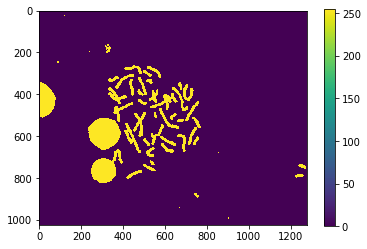

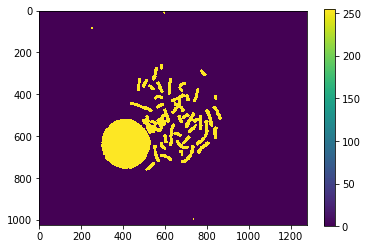

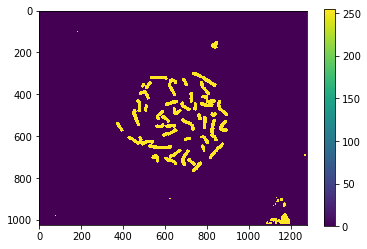

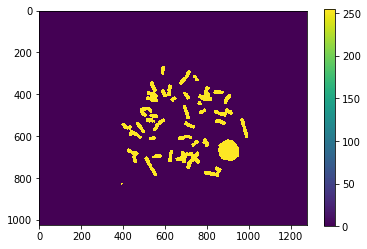

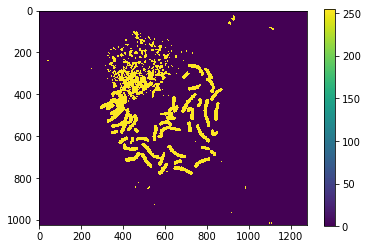

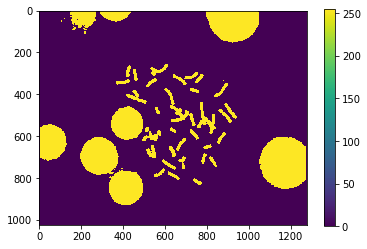

In [106]:
o_imgs = []

for b_img in b_imgs:
    o_img = opening(b_img, OPENING_KERNEL_SIZE)
    
    o_imgs.append(o_img)
    
    plt.imshow(o_img)
    plt.colorbar()
    plt.show()

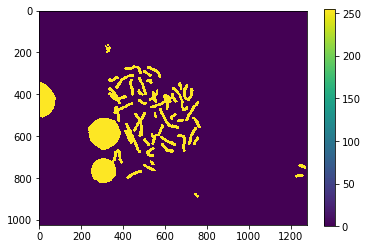

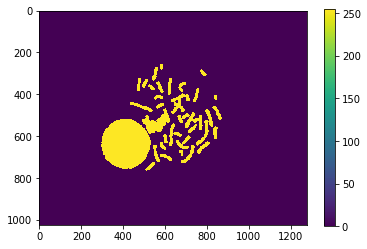

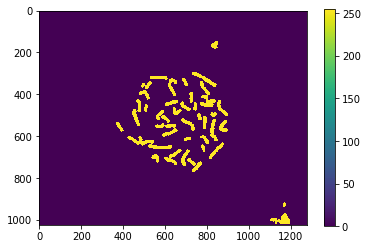

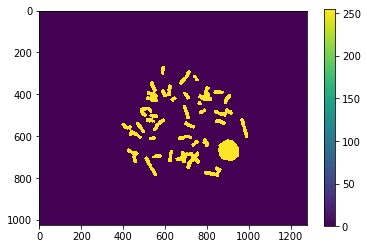

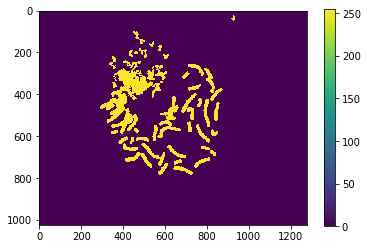

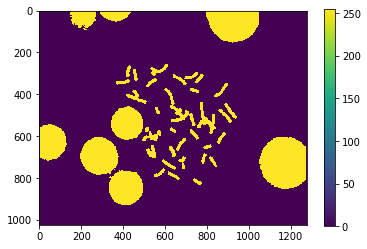

In [107]:
i_list = []
area_list = []
contour_list = []

# filtered images
f_imgs = [np.zeros_like(o_img) for o_img in o_imgs]

for o_img, f_img in zip(o_imgs, f_imgs):
    indexes, areas, contours = denoise(o_img, NOISE_THRESHOLD)
    
    i_list.append(indexes)
    area_list.append(areas)
    contour_list.append(contours)
    
    for i in indexes:
        cv2.drawContours(f_img, contours, i, 255, -1)
    
    plt.imshow(f_img)
    plt.colorbar()
    plt.show()

## 3. 去除血细胞

血细胞是大而圆的细胞，从中可以提取2个连通域特征：  
1. 面积很大  
2. 圆度较大  

圆度的计算方法是：  
C' = F / (max^2 * pi)  
C = min(1, C')  

OpenCV还提供了圈的检测函数，可以配合contour进行圆的检测：  
cv2.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) → circles    

In [108]:
# cannot correctly implement this for now
def circularity(contour):
    area = cv2.contourArea(contour)
    center, r = cv2.minEnclosingCircle(contour)
    
    ratio = np.min((1., area / (r * r * np.pi)))

    return ratio

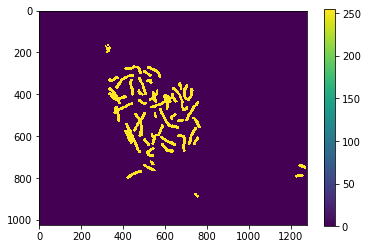

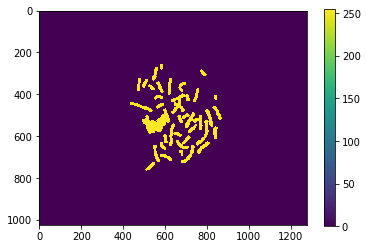

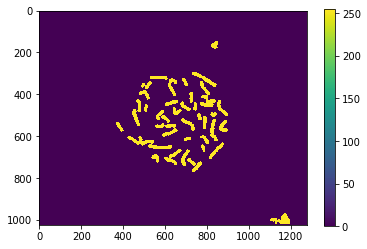

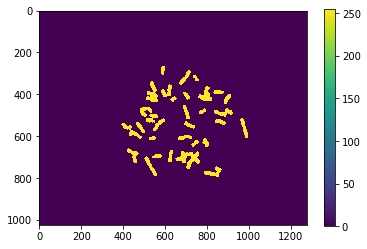

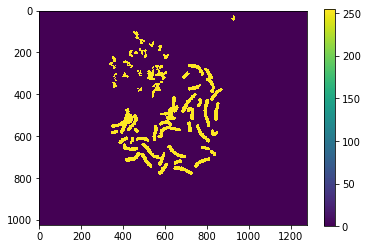

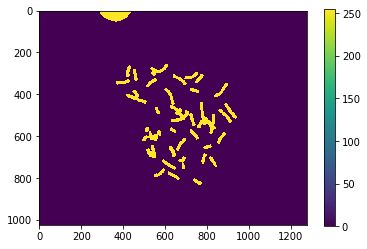

In [109]:
c_imgs = [np.zeros_like(f_img) for f_img in f_imgs]

# just record contour index
ci_list = []

for c_img, indexes, areas, contours in zip(c_imgs, i_list, area_list, contour_list):
    ci = []
    
    for index, area in zip(indexes, areas):
        # if circularity(contours[index]) > CIRCULARITY_THRESHOLD or area > CELL_THRESHOLD:
        if circularity(contours[index]) < CIRCULARITY_THRESHOLD and area < CELL_THRESHOLD:
            cv2.drawContours(c_img, contours, index, 255, -1)
            
            ci.append(index)
    ci_list.append(ci)
    
    # fig=plt.figure(figsize=(16,12))
    plt.imshow(c_img)
    plt.colorbar()
    plt.show()

## 4. 去除离群点

有一些边缘的血细胞有可能总体面积并不大，可以利用离群点方法去除。  


In [110]:
def dbscan_filter(contours, eps, min_samples):
    # find out contour centers
    centers = []
    for contour in contours:
        center, r = cv2.minEnclosingCircle(contour)
        centers.append(center)
        
    dataset = np.array(centers)
    pred = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(dataset)
    
    return pred

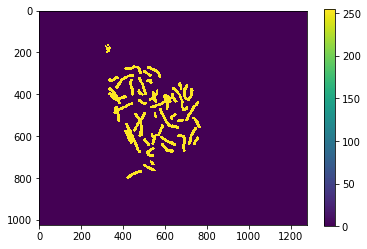

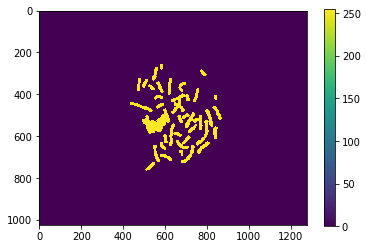

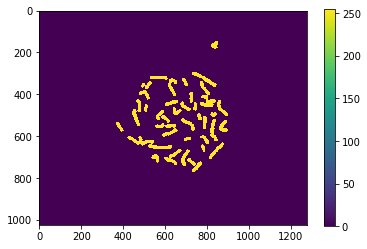

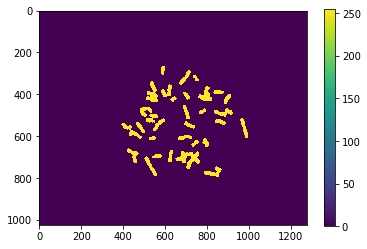

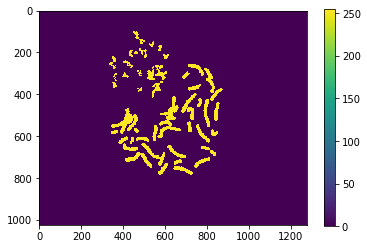

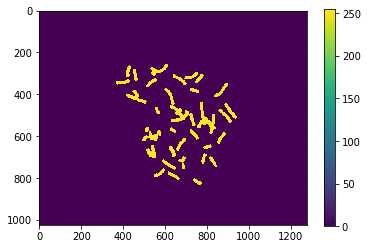

In [111]:
d_imgs = [np.zeros_like(c_img) for c_img in c_imgs]

di_list = []

for d_img, cis, contours in zip(d_imgs, ci_list, contour_list):
    targets = [contours[ci] for ci in cis]
    
    preds = dbscan_filter(targets, DBSCAN_EPS, DBSCAN_SAMPLES)

    dis = []
    for index, pred in zip(cis, preds):
        if pred != -1:
            cv2.drawContours(d_img, contours, index, 255, -1)
            
            dis.append(index)
    di_list.append(dis)
    
    # fig=plt.figure(figsize=(16,12))
    plt.imshow(d_img)
    plt.colorbar()
    plt.show()

## 结果展示

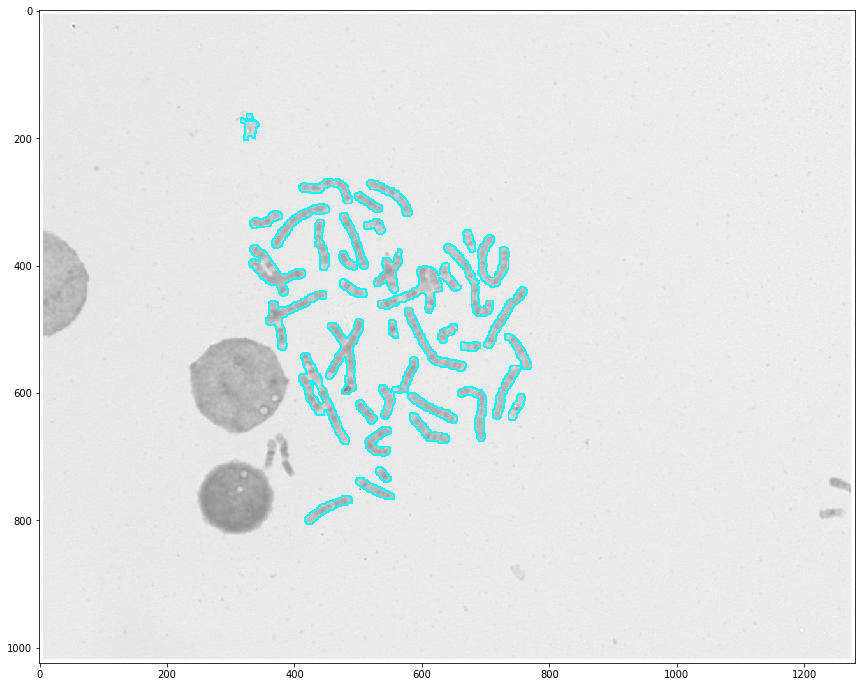

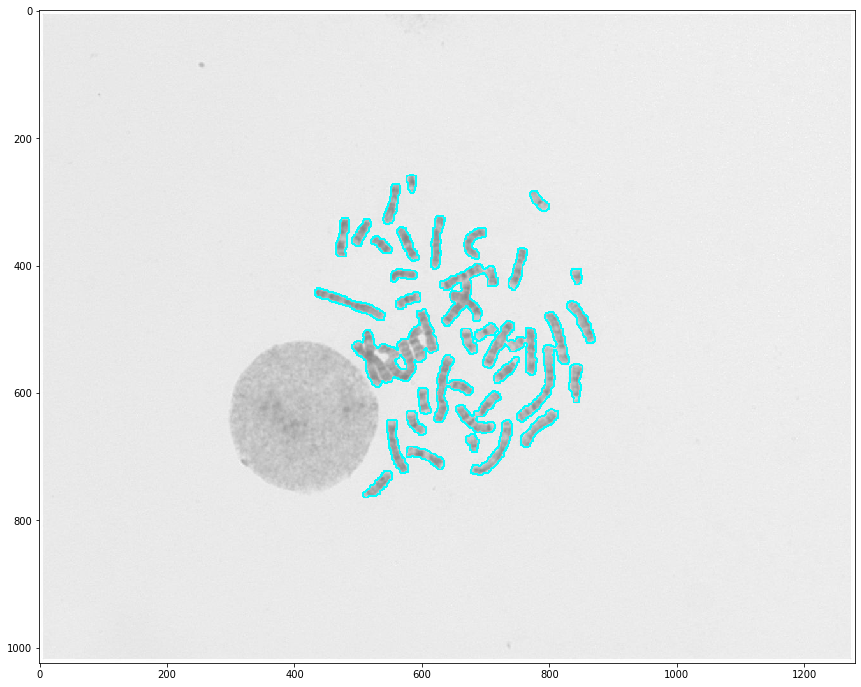

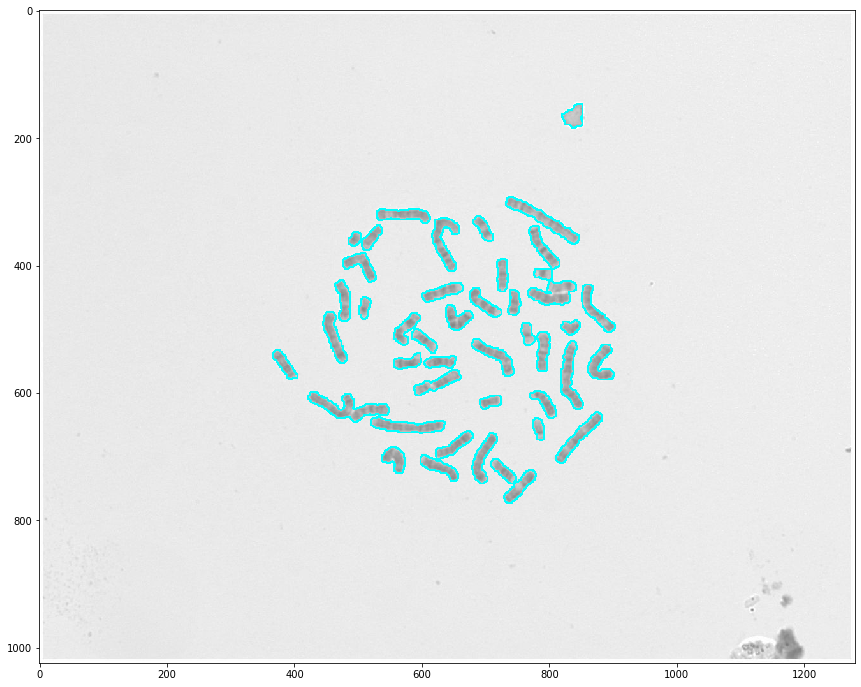

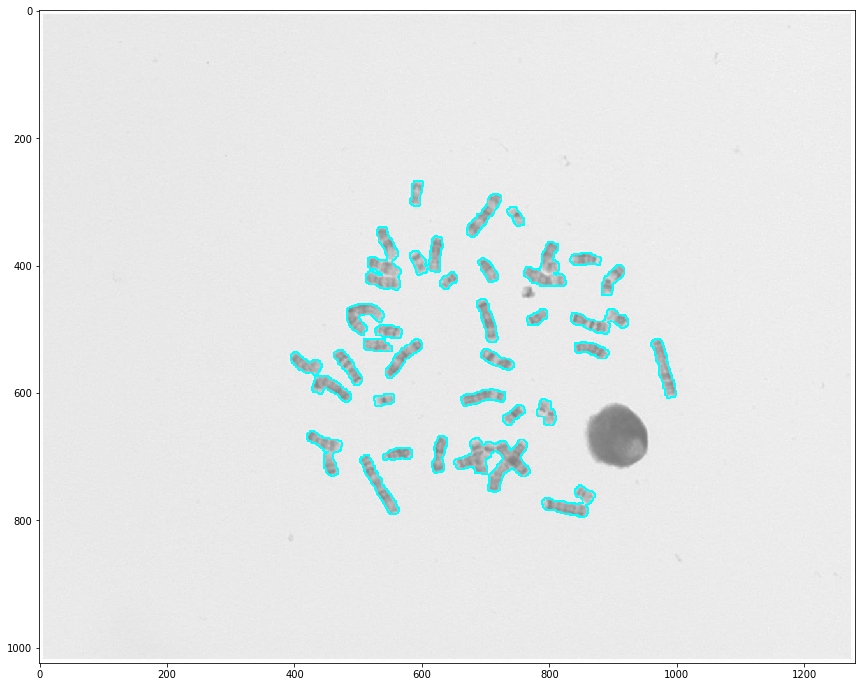

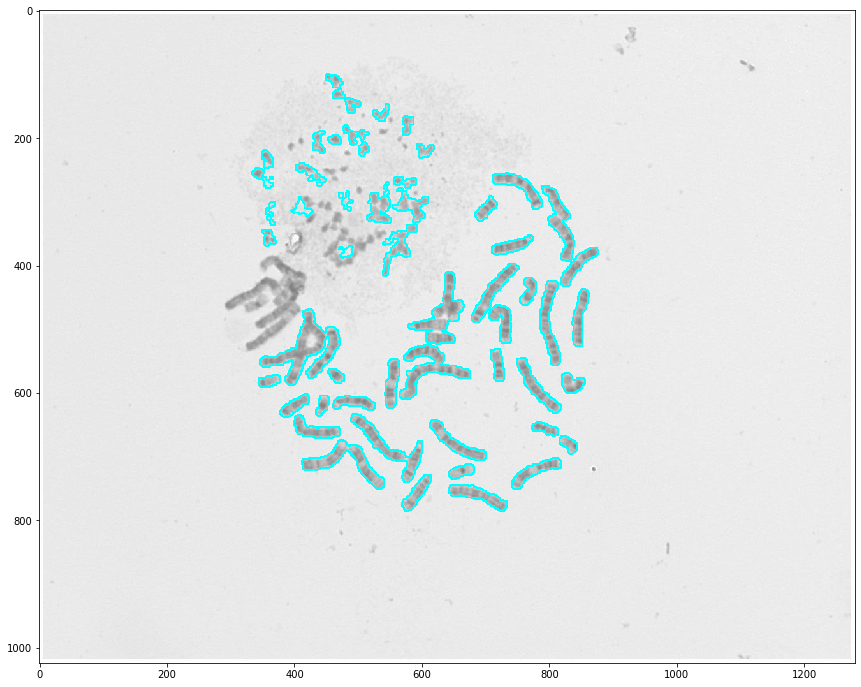

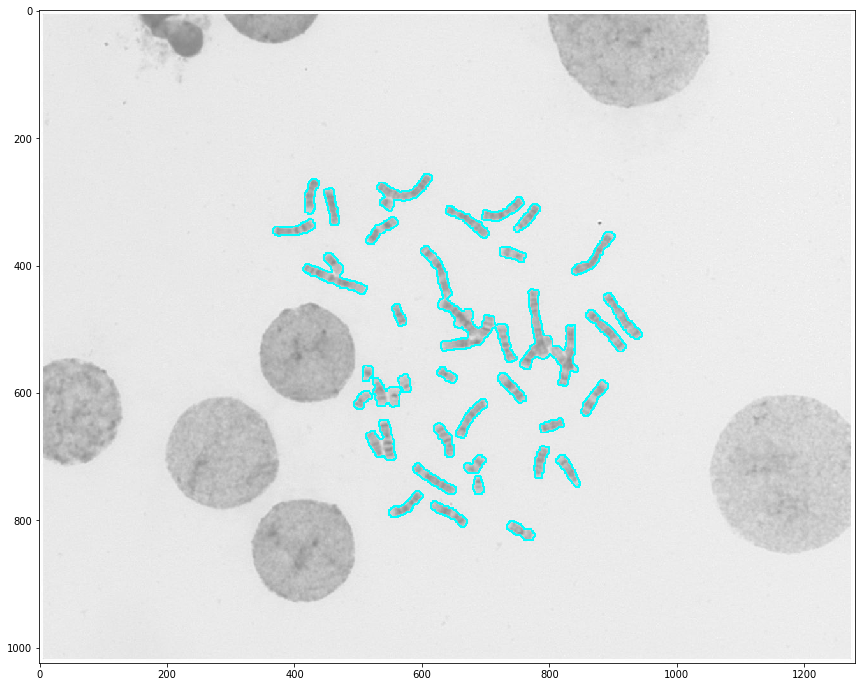

In [114]:
for d_indexes, contours, img in zip(di_list, contour_list, images):
    for di in d_indexes:
        cv2.drawContours(img, contours, di, (0, 255, 255), 2)
    
    fig=plt.figure(figsize=(16,12))
    plt.imshow(img)
    plt.show()